# Binning

First, we talk about mode permutation and modulation. Second, we explain how to roughly halve the number of trigonometric operations using symmetry.

## Mode permutation and modulation

Mode permutation/modulation parameters are $(a,b,c)$. Define $\phi(k) = ak+b$.

Original signal is $x$. After applying $(a,b,c)$ to $x$, we obtain another signal $y$ which satisfies:
$$y_t = x_{at+c} e^{2\pi i bt/N}$$
and
$$\hat{y}_{\phi(k)} = \hat{x}_k e^{2\pi i ck/N}.$$

In other words, from $x$ to $y$, modes get shuffled by $(a,b)$ and modulated according to $c$.

Let $h(k) = \lfloor \phi(k)B/N\rfloor$. In English, $h$ maps $k$ to its bin after applying the permutation $\phi$. Equivalently, $h^{-1}(b)$ is the set of modes $k$ such that $\phi(k)$ is in bin $b$.

Define $b$-th bin coeffcient as
$$Y_0^{b} = \sum_{k \in h^{-1}(b)} \hat{y}_{\phi(k)} = \sum_{k\in h^{-1}(b)} \hat{x}_k e^{2\pi i ck/n}.$$

To reiterate, we are summing over modes that got permuted or shuffled into the $b$-th bin.

We will then translate $y$ in order to do mode identification using matrix pencil. This corresponds to random modulation on $\hat{y}$.

## Translating $y$

Define $y^{\tau}$ as $y$ translated by $\tau$, i.e., $y^{\tau}_t = y_{t+\tau}$. This leads to
$$y^{\tau}_t = x_{a(t+\tau)+c} e^{2\pi i b(t+\tau)/N}$$
and
$$\hat{y}_{\phi(k)}^{\tau} = \hat{x}_k e^{2\pi i ck/N} e^{2\pi i \phi(k) \tau/N}.$$

The $b$-th bin coefficient is
$$U^b_{\tau} = \sum_{k\in h^{-1}(b)} \hat{y}^{\tau}_{\phi(k)} = \sum_{k\in h^{-1}(b)} \hat{y}_{\phi(k)} e^{2\pi i \tau \phi(k)/N} = \sum_{k \text{ in bin } b } \hat{y}_k e^{2\pi i \tau k/N}.$$

Treat $Y^b_{\tau}$ as a signal sampled at $\tau$. For mode identification, we will do $\tau= q,q\pm 2^0, q\pm 2^1, q\pm 2^2, q\pm 2^3,\ldots$ for say $~30$ different random $q$'s.

## Window functions

The above formula for $Y^b_{\tau}$ is not accurate. We need to take into account the smoothed boxcar filter. Here's the more precise details.

Fix a $\tau$. Let $P$ be support of the window. See notebook on filters for details. Here $P$ is just given to us.

Assume $P$ is odd. For $-\frac{P-1}{2}\leq t \leq \frac{P-1}{2}$, we compute $$u_{t \% P} = y^{\tau}_t e^{-2\pi i t/2B} W_t=x_{a(t+\tau)+c} e^{2\pi i b(t+\tau)/N} e^{-2\pi i t/2B} W_t.$$

The extra $e^{-2\pi i t/2B}$ factor is just a minor technical detail to slightly shift our filter so that we have nice bin boundaries. The value $W_t$ is mentioned in the notebook on boxcar filter.

Now, we have a $P$-vector $u$. We need to collapse it into a $B$ vector. Define
$$v_t = \sum_{j} u_{j B + t}.$$


Finally, do standard $B$-point FFT to get $\hat{v}$. This yields our bin coefficient
$$U^b_{\tau} = \hat{v}_b.$$

We will explain this signal processing in more details in a paper. It is kind of routine. Think of Poisson summation.

Equivalently, in the frequency domain, here's what is happening. We need to understand this also because we need to subtract away modes that are already found. This is the *most important* formula in this notebook:
$$U^b_{\tau} = \sum_{k} \hat{y}_{k} \hat{W}_{b,k} e^{2\pi i k\tau/N}= \sum_{k} \hat{x}_k \hat{W}_{b,\phi(k)} e^{2\pi i c k/N} e^{2\pi i \phi(k)\tau/N}$$
where $W_{b,k} = \hat{W}\left(\frac{b}{B} + \frac{1}{2B} - \frac{k}{N}\right)$.

Note that we are not being very accurate here. There is some loss in accuracy but for practical purpose, we can ignore this to simplify this document.

Let's see some action. We will compute the bin coefficients both from time domain and frequency domain, and check that they match up.

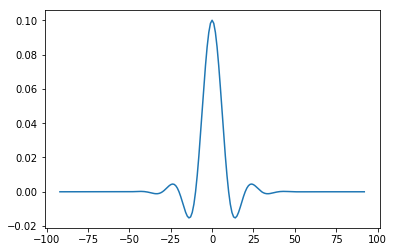

In bin 1
BinInTime:
P=185
Before FFT
[ 0.22530309-0.02176759j  0.09032469+0.20754942j -0.16947936+0.15004018j
 -0.19506870-0.11481949j  0.04892028-0.22100253j]
After FFT
[  4.85286256e-11 -4.68863837e-12j   1.12651546e+00 -1.08837926e-01j
   2.95668115e-10 -2.85655631e-11j  -1.57935706e-10 +1.52577916e-11j
   1.50076618e-10 -1.44997556e-11j]
Specific coef: (1.12651545528-0.108837925515j)
BinInFreq:
xi=0.048422
wf=0.565880
[ 0.00000000+0.j          1.12651546-0.10883793j  0.00000000+0.j
  0.00000000+0.j          0.00000000+0.j        ]
(1.12651546116-0.108837926083j)
Specific coef: (1.12651546116-0.108837926083j)


In [18]:
import numpy as np
from scipy.special import erf
import matplotlib.pyplot as plt

class Window:
    def __init__(self, N, B, delta=1e-6, kappa=1.0):
        assert (N % 2) == 1
        assert (B % 2) == 1
        
        self.N = N
        self.B = B
        self.delta = delta
        self.kappa = kappa
        
        N2 = (N - 1) / 2
        t = np.arange(N)
        t_centered = np.arange(-N2, N2 + 1)
        bins = self.which_bin(t)
        
        self.N2 = N2
        self.t = t
        self.t_centered = t_centered
        self.bins = bins
        
        # Work on our filter.
        w = (1 - 0.5 * kappa) / B  # Window width.
        c_delta = -np.log(delta)
        sigma_t = (2 * B * np.sqrt(2 * c_delta)) / (np.pi * kappa)
        sigma_f = 1.0 / (2.0 * np.pi * sigma_t)
        
        self.w = w
        self.c_delta = c_delta
        self.sigma_t = sigma_t
        self.sigma_f = sigma_f
        
        # P is size of support in time domain.
        P = 2 * np.sqrt(2 * c_delta) * sigma_t + 1
        tmp = int(np.ceil(P / B))
        if (tmp % 2) == 0:
            tmp += 1
        P = tmp * B
        assert (P % 2) == 1
        assert (P % B) == 0
        
        P2 = (P - 1) / 2
        s_centered = np.arange(-P2, P2 + 1)
        tmp = s_centered / sigma_t
        wt = np.exp(-0.5 * tmp * tmp) * (w * np.sinc(s_centered * w))  # This is centered.
        
        self.P = P
        self.P2 = P2
        self.s_centered = s_centered
        self.wt = wt  # P-vector.        
        self.N2 = N2
        
    def w_hat_func(self, b, k):
        B = self.B
        N = self.N
        w = self.w
        xi = (float(b) + 0.5) / B - float(k) / N
        print 'xi=%f' % xi
        tmp = 1.0 / (np.sqrt(2) * self.sigma_f)
        wf = 0.5 * (erf((xi + 0.5 * w) * tmp) - erf((xi - 0.5 * w) * tmp))
        return wf
 
    def do_plot(self):
        plt.plot(self.s_centered, self.wt)
        plt.show()
        
    def bin_in_time(self, x, perm_a=1, perm_b=0, mod_c=0, tau=0):
        # x is N-vector. Not centered.
        N = self.N
        B = self.B
        s = self.s_centered
        print 'P=%d' % self.P
        idx = np.arange(-self.P2, self.P2 + 1)
        idx = np.mod(perm_a * (s + tau) + mod_c, N)  # Positive mod.
        assert np.min(idx) >= 0
        assert np.max(idx) < N        
        
        exponent = np.mod(perm_b * (s + tau), N).astype(float) / N - (s.astype(float) / (2 * B))
        
        #print zip(range(-self.P2, self.P2+1), list(exponent * 2 * np.pi))
        #print zip(range(-self.P2, self.P2+1), self.wt)
        #print zip(range(-self.P2, self.P2+1), x[idx])
        
        tmp = x[idx] * self.wt * np.exp(2.0 * np.pi * 1j * exponent)
        tmp = np.fft.ifftshift(tmp)  # 0-indexed, uncentered.
        #print 'Before collapsing to B-vector (zero-indexed)'
        #print tmp
        tmp = tmp.reshape((self.P / B, B))
        tmp = np.sum(tmp, axis=0)  # Now we have a B-vector.
        print 'Before FFT'
        print tmp
        print 'After FFT'
        assert len(tmp) == B
        bin_coef = np.fft.fft(tmp)
        return bin_coef
    
    def bin_in_freq(self, list_k, list_coef, perm_a=1, perm_b=0, mod_c=0, tau=0):
        N = self.N
        B = self.B
        out = np.zeros(B, dtype=np.complex)
        for k, coef in zip(list_k, list_coef):
            b = self.which_bin(k, perm_a, perm_b)
            phi_k = np.mod(perm_a * k + perm_b, N)
            exponent = float(np.mod(mod_c * k, N)) / N + float(np.mod(phi_k * tau, N)) / N
            wf = self.w_hat_func(b, phi_k)
            out[b] += coef * np.exp(2 * np.pi * 1j * exponent) * wf
            print 'wf=%f' % wf
        return np.array(out)
    
    def which_bin(self, k, perm_a=1, perm_b=0):
        k = np.mod(k * perm_a + perm_b, self.N)
        return np.floor(k * self.B / self.N).astype(int)


def experiment():
    N = 1109  # Prime.
    B = 5
    window = Window(N, B)
    window.do_plot()

    # Try a single mode.
    xh = np.zeros(N)  # Not centered.
    k0 = 550
    c0 = 2.0
    xh[k0] = c0
    x = N * np.fft.ifft(xh)  # Not centered.
    
    # Permutation, modulation. Please try different combinations.
    perm_a = 3
    perm_b = 847
    mod_c = 45
    tau = 106
    
    b = window.which_bin(k0, perm_a=perm_a, perm_b=perm_b)
    print 'In bin %d' % b
    
    print 'BinInTime:'
    bin_coef = window.bin_in_time(x, perm_a=perm_a, perm_b=perm_b, mod_c=mod_c, tau=tau)
    print bin_coef
    print 'Specific coef: ' + str(bin_coef[b])
    
    print 'BinInFreq:'
    bin_coef2 = window.bin_in_freq([k0], [c0], perm_a=perm_a, perm_b=perm_b, mod_c=mod_c, tau=tau)
    print bin_coef2
    print bin_coef2[b]
    print 'Specific coef: ' + str(bin_coef2[b])
    
    assert np.sum(np.abs(bin_coef2 - bin_coef)) < 1e-6


experiment()


# Even $B$ and $P$

Above we assume that $B$ and $P$ are both odd. However, since we need to do FFT on $B$-vectors, it would be good for $B$ to contain just small factors, say 2 or 3 or 5. We need to sample at $P+1$ points from $-P/2$ to $P/2$ and take the average for the endpoints when merging into a $B$-vector, before doing a $B$-point FFT.

(Personal note: Look for `mpfft-singlefile/mpfft3.cpp`.)

# Optimization using symmetry

The motivation is that binning takes up most of the time and we can halve the number of trignometric operations by exploiting symmetry.

Recall that $x$ gets transformed into $y$ according to parameters $(a,b,c)$. This is the mode permutation and modulation. After we get $y$, we time-translate $y$ so as to perform mode identification on isolated modes in $y$. To summarize, this is the current setup: $$x \rightarrow^{a,b,c} y \rightarrow^{\tau} y^{\tau}.$$

Say the $\tau$'s we want are $\tau=q\pm s$. In other words, we want to evaluate
$$U^{b}_{q\pm s} = \sum_k \hat{y}_k W_{b,k} e^{2\pi i (q\pm s) k/N}.$$

Define $z$ as $y$ translated by $q$, i.e., $z_t = y_{t+q}$. We know $\hat{z}_k = \hat{y}_k e^{2\pi i k q/N}$.

Define $z^R$ and $z^I$ as even and odd components of $z$, that is
$$z_t^R = \frac{1}{2}(z_t + \text{conj}(z_{-t})); \quad z_t^I = \frac{1}{2i}(z_t - \text{conj}(z_{-t})).$$

Note that $z = z^R + i z^I$ and $\hat{z}_k = \hat{z}^R_k + i \hat{z}^I_k$. Note that $z^R,z^I$ are even in the time domain, e.g., $z^I_t$ is the conjugate of $z^I_{-t}$. Also, $\hat{z}^R_k = \text{Re}(\hat{z}_k)$ and $\hat{z}^I_k = \text{Im}(\hat{z}_k)$ and they are all real.

Apply time-translation $s$ to $\hat{z}^R$ and $\hat{z}^I$. The new setup is $$x \rightarrow^{a,b,c} y \rightarrow^q z^{q} \rightarrow^{R,I} z^R,z^I \rightarrow^{s} z^{R,s}, z^{I,s}.$$

## Combining bin coefficients

Say we have bin coefficients for $z^{R},z^{I}$ for a single $\tau$. We will show how to obtain the original bin coefficient for $y$ at $q\pm \tau$.

Fix a bin $b$. Fix a $\tau>0$. Bin coefficient for $z^R$ would be $$U^{R,b}_s:=\sum_k \text{Re}(\hat{z}_k) W_{b,k} e^{2\pi i ks/N} = \sum_k \text{Re}(\hat{y}_k e^{2\pi i q k/N}) W_{b,k} e^{2\pi i k s/N}.$$

Similarly, bin coefficient for $z^I$ would be $$U^{I,b}:=\sum_k \text{Im}(\hat{z}_k) W_{b,k} e^{2\pi i k s/N} = \sum_k \text{Im}(\hat{y}_k e^{2\pi i q k/N}) W_{b,k} e^{2\pi i ks/N}.$$

Observe that we can derive the two bin coefficients from the above two as $$U^b_{q+s} = U^{R,b}_s + i U^{I,b}_s$$ and $$U^b_{q-s} = \text{conj}(U^{R,b}_s) + i \text{conj}(U^{I,b}_s).$$

For the last equation above, we make use of the fact that $\text{conj}(W_{b,k} e^{2\pi i ks/N}) = W_{b,k} e^{-2\pi i ks/N}$.

## BinInFreq efficiency

For simplicity, say we found only one mode so far, and want to subtract its contribution from the bin coefficients.

Imagine our set of $\tau$'s look like $q\pm s_{0},q\pm s_1,\ldots,q\pm s_{M-1}$. So there are $2M$ different $\tau$'s.

Previously, for each $\tau$, we will need to compute one sinusoid in $\hat{y}_k = \hat{x}_k e^{2\pi i ck/N} e^{2\pi i \tau \phi(k)/N}$. In total, we need to compute $2M$ sinusoids (for each mode that is already found).

How about now? We want to compute $U^{R,b}_s,U^{I,b}_s$ with a single loop over $s$. First, we compute one sinusoid $e^{2\pi i ck/N} e^{2\pi i q\phi(k)/N}$. This will be reused in the loop over different $s_i$ in evaluating $\text{Re}(\hat{y}_k e^{2\pi i qk/N})$ and $\text{Im}(\hat{y}_k e^{2\pi i qk/N})$. For each $s_i$, we just need to compute only one sinusoid $e^{2\pi i ks/N}$. In total, we compute $M + 1$ sinusoids. This is roughly half as much work as before.

## BinInTime efficiency

Recall we need to form a $P$-vector, then collapse it before doing $B$-point FFT. The work needed is mostly in forming this $P$-vector for each signal we want to bin. Previously, we bin $y$ for each $\tau$. This means we would have $2M$ of these $P$-vectors. Each element of this $P$-vector is equal to $x_{a(t+\tau)+c} e^{2\pi i b(t+\tau) /N}$ essentially. (We are ignoring that $-1/2B$ term.) In total, we need $2M P$ sinusoids.

The new method calls for binning of $z^R,z^I$ simultaneously at fake $\tau=s$.

When binning $y$ at $\tau$, we evaluate $y^{\tau}_t e^{-2\pi i t/2B} W_t$.

So to bin $z^R$ at $s$, we evaluate $z^{R,s}_t e^{-2\pi i t/2B} W_t = z^R_{t+s} e^{-2\pi i t/2B} W_t$ which is equal to $$\frac{1}{2}(z_{t+s} + \text{conj}(z_{-(t+s)}))e^{-2\pi i t/2B} W_t$$
which is equal to
$$\frac{1}{2}(y_{q+t+s} + \text{conj}(y_{q-(t+s)}))e^{-2\pi i t/2B} W_t$$
which is equal to $$\frac{1}{2}(x_{a(q+t+s)+c}e^{2\pi i b(q+t+s)/N} + \text{conj}(x_{a(q-(t+s))+c}) e^{2\pi i b(-q+(t+s))/N} )e^{-2\pi i t/2B} W_t$$

The term $e^{2\pi i b q/N}$ can be evaluated just once. Per $s$ and per $t$, we just need one sinusoid $e^{2\pi i b(t+s)/N} e^{-2\pi i t/2B}$.

Now consider binning $z^I$ at $s$. Not surprisingly, we find that we can reuse the sinusoid used in computing $z^R$.

Per $s$ and per $t$ (there are $P$ of these), we will need to compute
$$\frac{1}{2i}(z_{t+s} - \text{conj}(z_{-(t+s)}))e^{-2\pi i t/2B} W_t$$ which will work out to
$$\frac{1}{2i}(x_{a(q+t+s)+c}e^{2\pi i b(q+t+s)/N} - \text{conj}(x_{a(q-(t+s))+c}) e^{2\pi i b(-q+(t+s))/N} )e^{-2\pi i t/2B} W_t.$$

Just reuse our computation earlier for binning $z^R$.

Hence, in total, we need about $MP + 1$ sinusoids which is half as much work as before.